In [93]:
import matplotlib.pyplot as plt

def dibujar_interseccion_esfera_foton(esfera, foton):
  interseccion, n = esfera.interseccion(foton)
    
  # Dibujamos la esfera
  x, y = esfera.getPlotCoords()
  plt.plot(x, y)
  plt.xlim(-2,2)
  plt.ylim(0,4)

  # Dibujar origen y vector de direccion
  plt.scatter(foton.pos[0], foton.pos[1], c='b')
  plt.quiver(foton.pos[0], foton.pos[1],
            foton.dire[0], foton.dire[1], color='b')
  if n[0] != None:
    plt.quiver(interseccion[0], interseccion[1], n[0], n[1], color='g')
  plt.axis('equal')
  

  # Dibujamos segmento de trayectoria
  plt.plot([foton.pos[0], interseccion[0]], [foton.pos[1], interseccion[1]], c='b')

  plt.scatter(interseccion[0], interseccion[1], c='r')
  # plt.scatter(interseccion_2[0], interseccion_2[1], c='r')
  plt.show()
  
def draw_fotones_hist(fotones, estructuras, expand=True):
  plt.figure(figsize=(10, 10))

  for estructura in estructuras:
    x, y = estructura.getPlotCoords()
    plt.plot(x, y)
  plt.gca().set_aspect('equal', adjustable='box')

  for foton in fotones:
    # Dibuujando camino de los fotones
    pos_hist = [p[0] for p in foton.poshist]
    x = [p[0] for p in pos_hist]
    y = [p[1] for p in pos_hist]
    plt.plot(x, y, c='b', alpha=0.05)

    # Dibujamos el vector de salida en la última posición
    if expand:
      plt.quiver(x[-1], y[-1], foton.dire[0], foton.dire[1], color='r', scale=50)  # Reduce el tamaño de las flechas

  plt.show()


In [42]:
from materiales.SimpleMaterial import MixedComplexMaterial
from propiedades.IndicesRefraccion import nComplex
from utilidades.aleatorios import *
from entidades.estructura import Esfera, Entorno
from entidades.fuente import FuenteMonocromatica
from entidades.interfase import interactuar_interfase
from entidades.SimulatedPhoton import SimulatedPhoton

# Entorno
entorno = Entorno()


# Esfera
radio = 1000
centro = np.array([0, 1500, 0])
n1 = nComplex(1.6, 0)
n2 = nComplex(1.456, 1e-3)

n_ext = nComplex(1, 0)
materialComplejo_int = MixedComplexMaterial(n=[n1,n2], fs=[0.99, 0.01])
materialComplejo_ext = MixedComplexMaterial(n=[n_ext], fs=[1])

ide = 1 
esfera1 = Esfera(1, centro, radio, material_int = materialComplejo_int, estructura_ext=entorno)

# Fuente fotones
fuente = FuenteMonocromatica(532, 0, dispersion_ang=GenerateRandomUniformAngle)

d_arbitraria_ampliacion = radio

Tiempo de ejecución:  0.1660311222076416


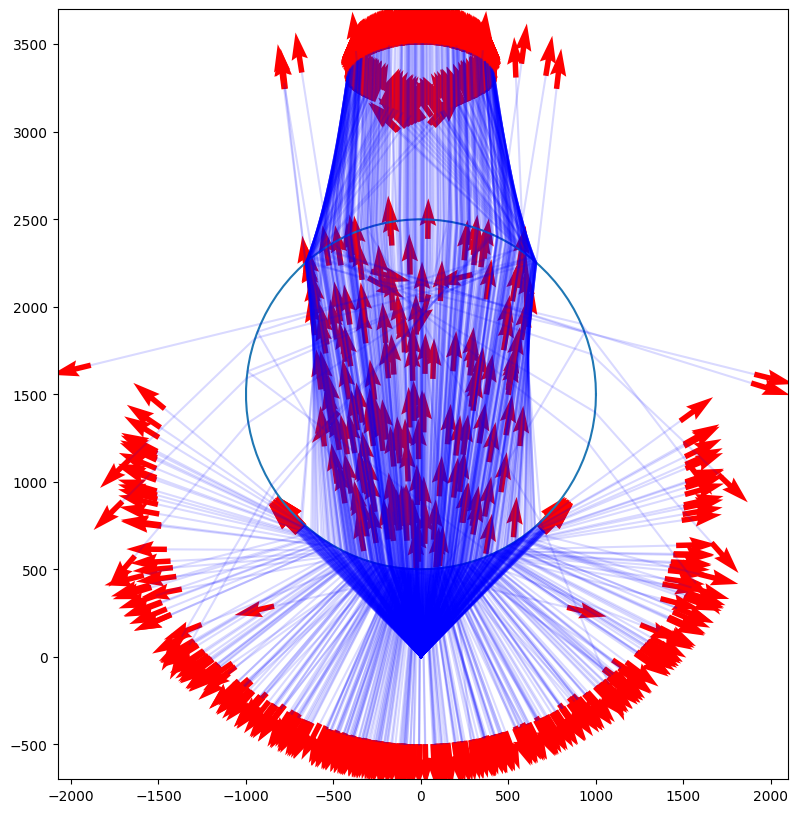

Fotones absorbidos:  148
Fotones total:  1000


In [56]:
import time

fotones = fuente.emitirN(1000, 0, 0, std_ang=np.pi/4)
# fotones_activos = []
fotones_inactivos = []
fotones_absorbidos = []
time_start = time.time()
# Fotones absorbidos
n_abs = 0
# alfa = materialComplejo.alfa(fotones[0].lamda)

estructuras = [esfera1]

for f in fotones:
  # Esta lógica hay que cambiarla
  for estructura in estructuras:
    while True:
      # print("\n")
      # print(f)
      p_int, n = estructura.interseccion(f)
      # print("Punto de intersección ", p_int)
      if p_int[0]==None:
        # print("\n")
        # print("Fotón no ha interactuado")
        # print("Estado final ", f)
        f.actualizarPos(f.pos+f.dire*d_arbitraria_ampliacion)
        fotones_inactivos.append(f)
        break
      
      # Comprobamos si se absorbe antes de interaccionar con una interfase
      l_pos = np.linalg.norm(p_int-f.pos)
      alfa = f.estructura.material_int.alfa(f.lamda)
      absorbido, labs = probAbs(l_pos, alfa)
      if absorbido:
        # print("\n")
        # print("Fotón no absborbido")
        # print("Estado final ", f)
        n_abs += 1
        f.actualizarPos(f.pos + f.dire*labs)
        fotones_inactivos.append(f)
        fotones_absorbidos.append(f)
        break
      
      # Si no es absorbido, calculamos la interacción con la interfase
      try:
        if f.estructura != estructura:
          estructura_foton = estructura.estructura_ext
          estructura_transmitida = estructura
        else:
          estructura_foton = estructura
          estructura_transmitida = estructura.estructura_ext
        
        n_foton = estructura_foton.material_int.indice_refraccion.calcular(f.lamda)
        n_trans = estructura_transmitida.material_int.indice_refraccion.calcular(f.lamda)
        # print(f)
        # print("N espacio foton ", n_foton)
        # print("N espacio transmitido ", n_trans)
        new_dire, result = interactuar_interfase(n, f, n_foton=n_foton, n_t = n_trans)
      except:
        raise Exception("Error")
      
      # Si se refleja cambiamos su posición y dirección
      if result == "reflect":
        # print("Fotón reflejado en la interfase")
        # print("Actualizando posición a ", p_int)
        f.actualizarPos(p_int)
        f.actualizarDire(new_dire)
        continue
      
      # Si se refracta cambiamos su posición, dirección y espacio en el que está
      if result == "refract":
        # print("Fotón refractado en la interfase")
        # print("Actualizando posición a ", p_int)
        f.actualizarPos(p_int)
        f.actualizarDire(new_dire)
        f.estructura = estructura_transmitida
        continue
      
time_end = time.time()
print("Tiempo de ejecución: ", time_end - time_start)
x, y = draw_fotones_hist(fotones_inactivos, esfera1)
print("Fotones absorbidos: ", n_abs)
print("Fotones total: ", len(fotones))

In [100]:
def generate_spheres(n, radio, x_min, x_max, y_min=50, y_max=20000):
    """
    Genera n esferas con centros (x, y, 0) tales que:
      - x está entre x_min y x_max.
      - y está entre y_min y y_max (con y_min >= 50).
      - Los centros no están tan próximos: la distancia entre dos centros >= 2 * radius.
    """
    centros = []  # Lista de centros (x, y, z)
    attempts = 0
    max_attempts = n * 1000  # Límite para evitar bucles infinitos

    while len(centros) < n and attempts < max_attempts:
        attempts += 1
        
        # Generamos coordenadas aleatorias dentro de los límites
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        z = 0  # En el plano z = 0
        
        new_center = (x, y, z)
        
        # Verificamos que la nueva esfera no se solape con ninguna ya generada
        overlap = False
        for cx, cy, cz in centros:
            distance = np.linalg.norm(np.array(new_center) - np.array((cx, cy, cz)))
            if distance < 2.2 * radio:
                overlap = True
                break
        
        if not overlap:
            centros.append(new_center)

    if len(centros) < n:
        print("No se pudieron generar todas las esferas sin superposición.")
    return centros

In [112]:
from materiales.SimpleMaterial import MixedComplexMaterial
from propiedades.IndicesRefraccion import nComplex
from utilidades.aleatorios import *
from entidades.estructura import Esfera, Entorno
from entidades.fuente import FuenteMonocromatica
from entidades.interfase import interactuar_interfase
from entidades.SimulatedPhoton import SimulatedPhoton

# Entorno
entorno = Entorno()


# Esfera
radio = 1000
altura = 1500

n1 = nComplex(1.6, 0)
n2 = nComplex(1.456, 1e-3)

n_ext = nComplex(1, 0)
materialComplejo= MixedComplexMaterial(n=[n1,n2], fs=[0.99, 0.01])

# Fuente fotones
fuente = FuenteMonocromatica(532, 0, dispersion_ang=GenerateRandomUniformAngle)

d_arbitraria_ampliacion = radio

n_estructuras = 1
estructuras = []
# Generamos los centros de manera que todo el diseño este
# centrado en 0, y se deje separación de 50 unidades entre
# cada esfera
# Que esten a la misma altura
centros = generate_spheres(n_estructuras, radio, -1000, 1000, radio + 100, 20000)
print(len(centros))
for i, centro in enumerate(centros):
  esfera = Esfera(i+1, centro, radio, material_int = materialComplejo, estructura_ext=entorno)
  estructuras.append(esfera)
# draw_fotones_hist([], estructuras)  

1


Tiempo de ejecución:  0.17971181869506836


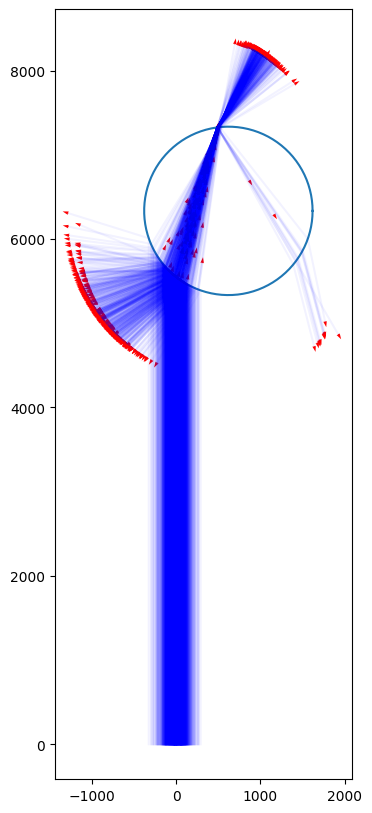

Fotones absorbidos:  109
Fotones total:  1000


In [113]:
import time

fotones = fuente.emitirN(1000, 0, 100, std_ang=0)
# fotones_activos = []
fotones_inactivos = []
fotones_absorbidos = []
time_start = time.time()
# Fotones absorbidos
n_abs = 0
# alfa = materialComplejo.alfa(fotones[0].lamda)

for f in fotones:
  # Esta lógica hay que cambiarla
  while True:
    min_pint, min_n = [None, None, None], None
    estructura_interaccion = None
    for i, estructura in enumerate(estructuras):
        # print("\n")
        # print(f)
        p_int, n = estructura.interseccion(f)
        if p_int[0]==None:
          continue
        
        if min_pint[0] == None:
          min_pint = p_int
          min_n = n
          estructura_interaccion = estructura
        else:
          if np.linalg.norm(f.pos - p_int) < np.linalg.norm(f.pos - min_pint):
            min_pint = p_int
            min_n = n
            estructura_interaccion = estructura
            
            
    if min_pint[0] == None:
      f.actualizarPos(f.pos+f.dire*d_arbitraria_ampliacion)
      fotones_inactivos.append(f)
      break
    
    # Comprobamos si se absorbe antes de interaccionar con una interfase
    l_pos = np.linalg.norm(min_pint-f.pos)
    alfa = f.estructura.material_int.alfa(f.lamda)
    absorbido, labs = probAbs(l_pos, alfa)
    if absorbido:
      # print("\n")
      # print("Fotón no absborbido")
      # print("Estado final ", f)
      n_abs += 1
      f.actualizarPos(f.pos + f.dire*labs)
      fotones_inactivos.append(f)
      fotones_absorbidos.append(f)
      break
    
    # Si no es absorbido, calculamos la interacción con la interfase
    try:
      if f.estructura != estructura_interaccion:
        estructura_foton = estructura.estructura_ext
        estructura_transmitida = estructura_interaccion
      else:
        estructura_foton = estructura_interaccion
        estructura_transmitida = estructura.estructura_ext
      
      n_foton = estructura_foton.material_int.indice_refraccion.calcular(f.lamda)
      n_trans = estructura_transmitida.material_int.indice_refraccion.calcular(f.lamda)
      # print(f)
      # print("N espacio foton ", n_foton)
      # print("N espacio transmitido ", n_trans)
      new_dire, result = interactuar_interfase(min_n, f, n_foton=n_foton, n_t = n_trans)
    except:
      raise Exception("Error")
    
    # Si se refleja cambiamos su posición y dirección
    if result == "reflect":
      # print("Fotón reflejado en la interfase")
      # print("Actualizando posición a ", p_int)
      f.actualizarPos(min_pint)
      f.actualizarDire(new_dire)
      continue
    
    # Si se refracta cambiamos su posición, dirección y espacio en el que está
    if result == "refract":
      # print("Fotón refractado en la interfase")
      # print("Actualizando posición a ", p_int)
      f.actualizarPos(min_pint)
      f.actualizarDire(new_dire)
      f.estructura = estructura_transmitida
      continue
      
time_end = time.time()
print("Tiempo de ejecución: ", time_end - time_start)
draw_fotones_hist(fotones_inactivos, estructuras)
print("Fotones absorbidos: ", n_abs)
print("Fotones total: ", len(fotones))

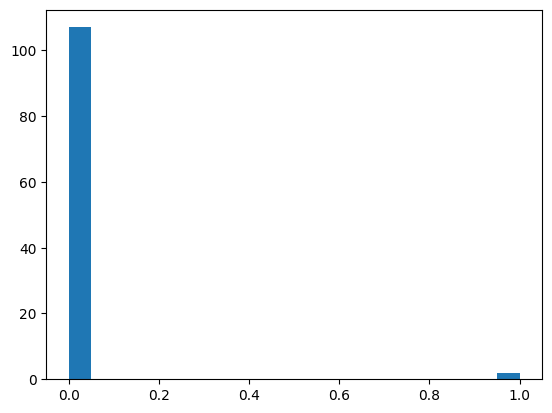

In [114]:
rebotes = []
for f in fotones_absorbidos:
  rebotes.append(f.getNumeroReflexiones())
plt.hist(rebotes, bins=20)
plt.show()